In [2]:
from main.codes.RepetitionCode import RepetitionCode
from main.QPUs.SquareLatticeQPU import SquareLatticeQPU
import stim

from main.compiling.compilers.AncillaPerCheckCompiler import AncillaPerCheckCompiler
from main.compiling.noise.models import PhenomenologicalNoise
from main.printing.Printer2D import Printer2D
import math
import networkx as nx
import pymatching
from typing import Callable, List
import numpy as np

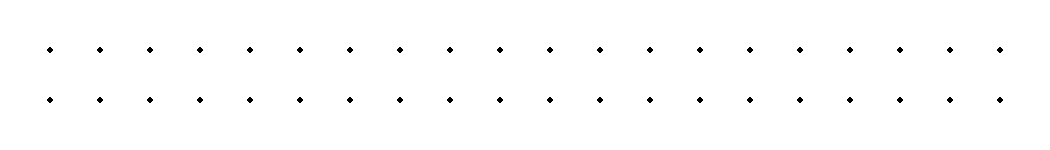

In [3]:
test_qpu = SquareLatticeQPU(20)
printer = Printer2D(scale_factor=50)
printouts = printer.print_qpu(test_qpu, 'small_18_qpu')
printouts[0].image

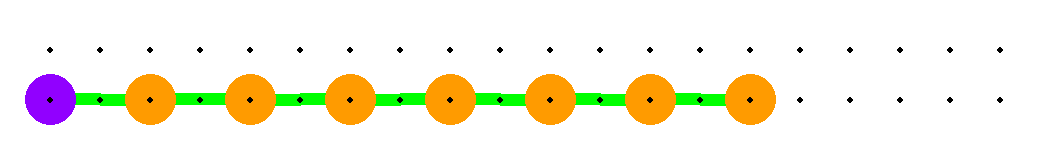

In [4]:
rep_code = RepetitionCode(8)
test_qpu.embed(rep_code, (0, 0), 0)
printer = Printer2D(scale_factor=50)
printouts = printer.print_qpu(test_qpu, 'small_18_rep_code_qpu')
printouts[0].image

In [92]:
noise_model = PhenomenologicalNoise(0.1, 0.1)
test_compiler = AncillaPerCheckCompiler(noise_model)
test_compiler.compile_code(
    rep_code, )
circuit = Circuit()
circuit.to_stim(test_compiler.gates_at_timesteps)


In [93]:
print(circuit.stim_circuit)

R 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
DEPOLARIZE1(0.1) 0 1 2 3 4 5 6 7
TICK
CX 0 8 1 9 2 10 3 11 4 12 5 13 6 14
TICK
CX 1 8 2 9 3 10 4 11 5 12 6 13 7 14
X_ERROR(0.1) 8 9 10 11 12 13 14
TICK
MR 8
DETECTOR rec[-1]
MR 9
DETECTOR rec[-1]
MR 10
DETECTOR rec[-1]
MR 11
DETECTOR rec[-1]
MR 12
DETECTOR rec[-1]
MR 13
DETECTOR rec[-1]
MR 14
DETECTOR rec[-1]
TICK
R 8 9 10 11 12 13 14
DEPOLARIZE1(0.1) 0 1 2 3 4 5 6 7
TICK
CX 0 8 1 9 2 10 3 11 4 12 5 13 6 14
TICK
CX 1 8 2 9 3 10 4 11 5 12 6 13 7 14
X_ERROR(0.1) 8 9 10 11 12 13 14
TICK
MR 8
DETECTOR rec[-1] rec[-8]
MR 9
DETECTOR rec[-1] rec[-8]
MR 10
DETECTOR rec[-1] rec[-8]
MR 11
DETECTOR rec[-1] rec[-8]
MR 12
DETECTOR rec[-1] rec[-8]
MR 13
DETECTOR rec[-1] rec[-8]
MR 14
DETECTOR rec[-1] rec[-8]
TICK
R 8 9 10 11 12 13 14
DEPOLARIZE1(0.1) 0 1 2 3 4 5 6 7
TICK
CX 0 8 1 9 2 10 3 11 4 12 5 13 6 14
TICK
CX 1 8 2 9 3 10 4 11 5 12 6 13 7 14
X_ERROR(0.1) 8 9 10 11 12 13 14
TICK
MR 8
DETECTOR rec[-1] rec[-8]
MR 9
DETECTOR rec[-1] rec[-8]
MR 10
DETECTOR rec[-1

In [94]:
print(repr(circuit.stim_circuit.detector_error_model()))


stim.DetectorErrorModel('''
    error(0.0666667) D0 D1
    error(0.1) D0 D7
    error(0.0666667) D0 L0
    error(0.0666667) D1 D2
    error(0.1) D1 D8
    error(0.0666667) D2 D3
    error(0.1) D2 D9
    error(0.0666667) D3 D4
    error(0.1) D3 D10
    error(0.0666667) D4 D5
    error(0.1) D4 D11
    error(0.0666667) D5 D6
    error(0.1) D5 D12
    error(0.0666667) D6
    error(0.1) D6 D13
    error(0.0666667) D7 D8
    error(0.1) D7 D14
    error(0.0666667) D7 L0
    error(0.0666667) D8 D9
    error(0.1) D8 D15
    error(0.0666667) D9 D10
    error(0.1) D9 D16
    error(0.0666667) D10 D11
    error(0.1) D10 D17
    error(0.0666667) D11 D12
    error(0.1) D11 D18
    error(0.0666667) D12 D13
    error(0.1) D12 D19
    error(0.0666667) D13
    error(0.1) D13 D20
    error(0.0666667) D14 D15
    error(0.1) D14 D21
    error(0.0666667) D14 L0
    error(0.0666667) D15 D16
    error(0.1) D15 D22
    error(0.0666667) D16 D17
    error(0.1) D16 D23
    error(0.0666667) D17 D18
    error(0.1) D

In [95]:
detector_sampler = circuit.stim_circuit.compile_detector_sampler()
one_sample = detector_sampler.sample(shots=1)[0]
print(one_sample)
for k in range(0, len(one_sample), 7):
    timeslice = one_sample[k:k+7]
    print("".join("_1"[e] for e in timeslice))


[1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
1_11_1_
_____1_
_______
____1__
1___1__
_____1_
___11_1
_____1_
11_____
_______
_______


In [96]:
##########################################################
#################### BEGIN GLUE CODE #####################
##########################################################




def predict_observable_errors_using_pymatching(circuit: stim.Circuit,
                                               det_samples: np.ndarray,
                                               ) -> np.ndarray:
    """Turn detection events into predicted observable errors."""
    error_model = circuit.detector_error_model(decompose_errors=True)
    matching_graph = detector_error_model_to_pymatching_graph(error_model)

    num_shots = det_samples.shape[0]
    num_obs = circuit.num_observables
    num_dets = circuit.num_detectors
    assert det_samples.shape[1] == num_dets

    predictions = np.zeros(shape=(num_shots, num_obs), dtype=np.bool8)
    for k in range(num_shots):
        expanded_det = np.resize(det_samples[k], num_dets + 1)
        expanded_det[-1] = 0
        predictions[k] = matching_graph.decode(expanded_det)
    return predictions


def detector_error_model_to_pymatching_graph(model: stim.DetectorErrorModel) -> pymatching.Matching:
    """Convert a stim error model into a pymatching graph."""
    g = detector_error_model_to_nx_graph(model)
    num_detectors = model.num_detectors
    num_observables = model.num_observables

    # Add spandrels to the graph to ensure pymatching will accept it.
    # - Make sure there's only one connected component.
    # - Make sure no detector nodes are skipped.
    # - Make sure no observable nodes are skipped.
    for k in range(num_detectors):
        g.add_node(k)
    g.add_node(num_detectors + 1)
    for k in range(num_detectors + 1):
        g.add_edge(k, num_detectors + 1, weight=9999999999)
    g.add_edge(num_detectors, num_detectors + 1, weight=9999999999,
               qubit_id=list(range(num_observables)))

    return pymatching.Matching(g)


def detector_error_model_to_nx_graph(model: stim.DetectorErrorModel) -> nx.Graph:
    """Convert a stim error model into a NetworkX graph."""

    g = nx.Graph()
    boundary_node = model.num_detectors
    g.add_node(boundary_node, is_boundary=True, coords=[-1, -1, -1])

    def handle_error(p: float, dets: List[int], frame_changes: List[int]):
        if p == 0:
            return
        if len(dets) == 0:
            # No symptoms for this error.
            # Code probably has distance 1.
            # Accept it and keep going, though of course decoding will probably perform terribly.
            return
        if len(dets) == 1:
            dets = [dets[0], boundary_node]
        if len(dets) > 2:
            raise NotImplementedError(
                f"Error with more than 2 symptoms can't become an edge or boundary edge: {dets!r}.")
        if g.has_edge(*dets):
            edge_data = g.get_edge_data(*dets)
            old_p = edge_data["error_probability"]
            old_frame_changes = edge_data["qubit_id"]
            # If frame changes differ, the code has distance 2; just keep whichever was first.
            if set(old_frame_changes) == set(frame_changes):
                p = p * (1 - old_p) + old_p * (1 - p)
                g.remove_edge(*dets)
        g.add_edge(*dets, weight=math.log((1 - p) / p),
                   qubit_id=frame_changes, error_probability=p)

    def handle_detector_coords(detector: int, coords: np.ndarray):
        g.add_node(detector, coords=coords)

    eval_model(model, handle_error, handle_detector_coords)

    return g


def eval_model(
        model: stim.DetectorErrorModel,
        handle_error: Callable[[float, List[int], List[int]], None],
        handle_detector_coords: Callable[[int, np.ndarray], None]):
    """Interprets the error model instructions, taking care of loops and shifts.

    Makes callbacks as error mechanisms are declared, and also when detector
    coordinate data is declared.
    """
    det_offset = 0
    coords_offset = np.zeros(100, dtype=np.float64)

    def _helper(m: stim.DetectorErrorModel, reps: int):
        nonlocal det_offset
        nonlocal coords_offset
        for _ in range(reps):
            for instruction in m:
                if isinstance(instruction, stim.DemRepeatBlock):
                    _helper(instruction.body_copy(), instruction.repeat_count)
                elif isinstance(instruction, stim.DemInstruction):
                    if instruction.type == "error":
                        dets: List[int] = []
                        frames: List[int] = []
                        t: stim.DemTarget
                        p = instruction.args_copy()[0]
                        for t in instruction.targets_copy():
                            if t.is_relative_detector_id():
                                dets.append(t.val + det_offset)
                            elif t.is_logical_observable_id():
                                frames.append(t.val)
                            elif t.is_separator():
                                # Treat each component of a decomposed error as an independent error.
                                # (Ideally we could configure some sort of correlated analysis; oh well.)
                                handle_error(p, dets, frames)
                                frames = []
                                dets = []
                        # Handle last component.
                        handle_error(p, dets, frames)
                    elif instruction.type == "shift_detectors":
                        det_offset += instruction.targets_copy()[0]
                        a = np.array(instruction.args_copy())
                        coords_offset[:len(a)] += a
                    elif instruction.type == "detector":
                        a = np.array(instruction.args_copy())
                        for t in instruction.targets_copy():
                            handle_detector_coords(
                                t.val + det_offset, a + coords_offset[:len(a)])
                    elif instruction.type == "logical_observable":
                        pass
                    else:
                        raise NotImplementedError()
                else:
                    raise NotImplementedError()
    _helper(model, 1)

##########################################################
##################### END GLUE CODE ######################
##########################################################


In [97]:
def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    shots = circuit.compile_detector_sampler().sample(
        num_shots, append_observables=True)

    detector_parts = shots[:, :circuit.num_detectors]
    actual_observable_parts = shots[:, circuit.num_detectors:]
    predicted_observable_parts = predict_observable_errors_using_pymatching(
        circuit, detector_parts)

    num_errors = 0
    for actual, predicted in zip(actual_observable_parts, predicted_observable_parts):
        if not np.array_equal(actual, predicted):
            num_errors += 1
    return num_errors


In [100]:
count_logical_errors(circuit.stim_circuit, 1000)

72